In [183]:
A=[1;1;1]
B=[2;2;2;2]
display(A[end])

1

## Data preprocessing

Not all of those 605 variables are used in the model, so I preprocessed the data and classified the data I need to use. We divide the energy sources into two categories for the further analysis, one is renewable energy like the Electricity,Fuel ethanol,Nuclear fuel,Solar thermal and Wood; the other is the unrenewable energyoil, gasoline, petroleum, coal, natural gas.

<!-- |Abbreviation|Full Name|Asphalt and road oil|Aviation gasoline|Coal|Crude oil|Distillate fuel oil|Electricity|Fuel ethanol|Fossil fuel|Petrochemical feedstocks|
|----|---|---|---|---|---|---|---|---|---|---|
|UC|Unrenewable Consumption|12|24|84|88|173|150|178|187|
|UPR|Unrenewable Price |13| 25|83|      |116|170| ||188|
|UED|Unrenewable Expenditure|15|27|85||118|176|144||190|
|UE|Unrenewable Export| | |29|           |   |123||||
|UI|Unrenewable Import| | |  |           |   |127||||
|UP|Unrenewable Production| | |  |       |   ||148|||

|Abbreviation|Full Name|Geothermal energy|
|----|---|---|
|UC|Unrenewable Consumption|199|
|UPR|Unrenewable Price ||
|UED|Unrenewable Expenditure||
|UE|Unrenewable Export| |
|UI|Unrenewable Import| |
|UP|Unrenewable Production| | -->


## Energy Proﬁle for each state(AZ, TX, NM, CA)

We selected several important variables for energy profile as below:

|Abbreviation|Full Name|
|------|---|
|RC|Renewable Consumption|
|UC|Unrenewable Consumption|
|RP|Renewable Production|
|UP|Unrenewable Production|
|RI|Renewable Import|
|RE|Renewable Export|
|RED|Renewable Expenditure|
|UED|Unrenewable Expenditure|
|SRP|Share of Renewable Production|
|SRC|Share of Renewable Consumption|
|RCPR|Renewable Consumption-Production Ratio|

## Tradeoffs and Regularization

In order to predict future energy consumption, imports and exports, etc., we adopt the Tradeoffs and Regularization to fit the data of the past few decades.

The reasonable choice of tradeoff value help us build a excellent fitting model that predicts the underlying training dataset well (low bias) and producing a model that doesn't change much with the training dataset (low variance).


We choose $\lambda=0.5$ as the trade-off value to fit a relatively smooth curve with little error from the original data set.

The objective function is $||Smoothness||+\lambda||Error||$, so large $\lambda$ will leads to smoother fitted curve; and smaller $\lamba$ will leads to smaller error with original data but it may cause overfitting.

In [244]:
#fitting model
using JuMP, Gurobi
function solveOpt(λ,u)
     m = Model(Gurobi.Optimizer) # need Gurobi since it's nonlinear
    set_optimizer_attribute(m,"OutputFlag",0)
    @variable(m, p[1:40]>=0) #production of renewable energy in AZ
    
    @objective(m, Min, sum((p[2:40]-p[1:39]).^2)+ λ*sum( (p[1:40]-u[1:40]).^2 ) )
    optimize!(m)
    error=value(sum( (p[1:40]-u[1:40]).^2 )).^0.5
    smoothness=value(sum((p[2:40]-p[1:39]).^2)+ λ*sum( (p[1:40]-u[1:40]).^2 ))
    xopt = value.(p)
    return (error,smoothness,xopt)
end

solveOpt (generic function with 1 method)

I use part of historical data to make predictions for the next 10 years.\
Because some data like RE fluctuate greatly, I will based on the data of recent years rather than the past few decades.

In [245]:
#prediction
using Convex, SCS

function solveOpt1(λ,b,span)
    x = Variable(3)
    A1=ones(span,1)
    A2=[i for i in 2010-span:2009]
    A3=[i.^2 for i in 2010-span:2009]
    A=[A1 A2 A3]
    b=b[end-span+1:end]
    
    problem = minimize(norm(A * x - b,2)+λ*norm(x,2))
    solve!(problem, SCS.Optimizer(verbose=false))
    println(problem.status)
    println(x.value)
    return x.value
end


solveOpt1 (generic function with 2 methods)

## Energy Proﬁle Analysis and Prediction

### Renewable Expenditure (RED)

The total expenditure of renewable energy is composed of Fuel ethanol and excluding denaturant(EMTCV), Electricity(ESTCV),Nuclear fuel(NUETV) and Wood and waste(WWTCV)'s total expenditures.

So we get the total expenditure of renewable energy  by the equation: $$RED=EMTCV+ESTCV+NUETV+ WWTCV$$

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
ALMOST_OPTIMAL
[-0.07564262418083974; -75.82158733125156; 0.03924932521252816]
ALMOST_OPTIMAL
[285693.5600597956; -1073.3104656468015; 0.4710822879002448]
ALMOST_OPTIMAL
[-6.278887195920867; -39.53104954109175; 0.020097821157459048]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228


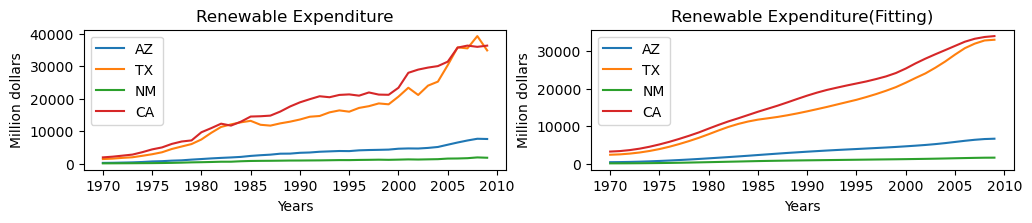

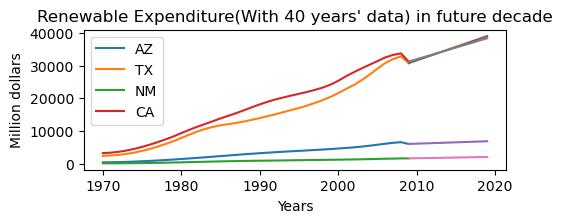

ALMOST_OPTIMAL
[-1.804634624550234; -677.568085611352; 0.3449976724694512]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228


PyObject <matplotlib.legend.Legend object at 0x7f94f6cd4ed0>

In [246]:
using PyPlot,PyCall,Convex, SCS
year=[i for i in 1970:2009]
RED_AZ=[250.81574;281.98975;344.52488;413.20603;528.89461;698.31133;781.11293;943.00206;
    1042.08887;1260.331;1438.67983;1632.26342;1792.51171;1928.28664;2097.6365;2400.37468;
    2615.34581;2787.36871;3082.70829;3110.26364;3358.71978;3455.58215;3684.16668;3800.24367;
    3910.81016;3880.72786;4118.83943;4214.4792;4270.39955;4343.76184;4616.93279;4703.91549;
    4677.90715;4864.75526;5154.59;5848.13104;6531.17353;7151.69273;7683.59609;7611.48122]

RED_TX=[1438.18533;1568.20123;1802.4685;1981.73438;2432.313;2915.49005;3520.88247;4537.18236;
    5299.48849;6051.96579;7466.6194;9513.62245;11328.47209;12111.45261;12742.00028;13203.3842;
    11989.66443;11731.72356;12421.94811;12949.53854;13616.26983;14470.05152;14695.91527;15814.10075;
    16417.35731;16022.37852;17185.46356;17722.50418;18566.32067;18295.26036;20664.6054;23395.44971;
    21166.98575;24055.09419;25279.06043;30356.82028;35819.872;35526.50148;39307.4475;34894.545]

RED_NM=[107.46873;118.4856;134.20101;147.39748;168.09645;180.99432;214.07253;259.28415;327.38055;
    414.08866;462.75406;530.55247;609.07957;614.23293;755.17619;844.64457;881.33393;902.41154;
    935.20401;974.48193;981.76189;1005.82882;1025.97199;1066.33123;1111.5837;1106.56733;1163.08861;
    1194.67947;1240.38031;1194.74198;1255.9944;1331.0047;1285.20662;1344.30257;1398.7541;1579.36048;
    1609.54798;1700.52468;1936.14128;1835.97152]
RED_CA=[1949.06043;2169.05432;2486.80207;2807.32838;3549.43689;4410.59382;5015.47734;6098.16936;
    6841.83164;7174.10971;9685.65811;10958.68571;12327.89986;11736.67443;12935.07771;14527.59515;
    14618.98892;14809.15655;16054.99063;17624.54517;18901.48844;19875.17027;20779.36309;20473.1917;
    21186.26538;21346.03657;20961.35073;21945.17467;21286.1183;21223.37847;23395.96907;27999.77263;
    28986.90022;29609.60677;30064.97049;31426.99586;35753.95877;36378.67005;35995.46702;36367.36861]

figure(figsize=(12,4))
subplot(221)
plot(year,RED_AZ)
plot(year,RED_TX)
plot(year,RED_NM)
plot(year,RED_CA)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Expenditure")
legend(["AZ", "TX","NM","CA"])

λ=0.1
(error,smoothness,RED_AZ_opt)=solveOpt(λ,RED_AZ)
(error,smoothness,RED_TX_opt)=solveOpt(λ,RED_TX)
(error,smoothness,RED_NM_opt)=solveOpt(λ,RED_NM)
(error,smoothness,RED_CA_opt)=solveOpt(λ,RED_CA)

subplot(222)
plot(year,RED_AZ_opt)
plot(year,RED_TX_opt)
plot(year,RED_NM_opt)
plot(year,RED_CA_opt)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Expenditure(Fitting)")
legend(["AZ", "TX","NM","CA"])

span=10
P1=ones(11,1)
P2=[i for i in 2009:2019]
P3=[i.^2 for i in 2009:2019]
pre_year=[P1 P2 P3]
xopt=solveOpt1(λ,RED_AZ_opt,span)
pre_RED_AZ=pre_year*xopt
RED_AZ_opt[end]=pre_RED_AZ[1]

xopt=solveOpt1(λ,RED_TX_opt)
pre_RED_TX=pre_year*xopt
pre_RED_TX=pre_year*xopt
RED_TX_opt[end]=pre_RED_TX[1]

xopt=solveOpt1(λ,RED_NM_opt)
pre_RED_NM=pre_year*xopt
pre_RED_NM=pre_year*xopt
RED_NM_opt[end]=pre_RED_NM[1]

xopt=solveOpt1(λ,RED_CA_opt)
pre_RED_CA=pre_year*xopt
pre_RED_CA=pre_year*xopt
RED_CA_opt[end]=pre_RED_CA[1]


figure(figsize=(12,4))
subplot(221)
plot(year,RED_AZ_opt)
plot(year,RED_TX_opt)
plot(year,RED_NM_opt)
plot(year,RED_CA_opt)
plot(P2,pre_RED_AZ)
plot(P2,pre_RED_TX)
plot(P2,pre_RED_NM)
plot(P2,pre_RED_CA)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Expenditure(With 40 years' data) in future decade")
legend(["AZ", "TX","NM","CA"])


### Renewable Import (RI)
According to the table, electricity is the only renewable resource imported. We use this formula to calculate it:
$$RI=ELIMV$$

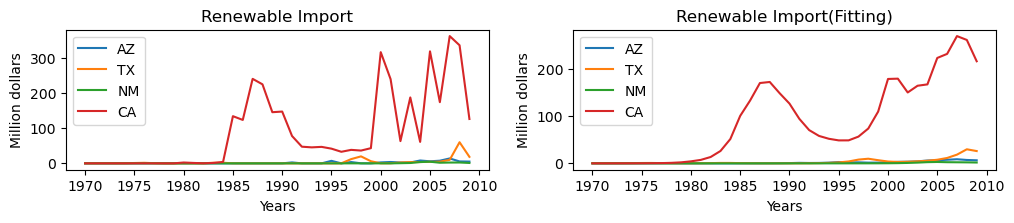

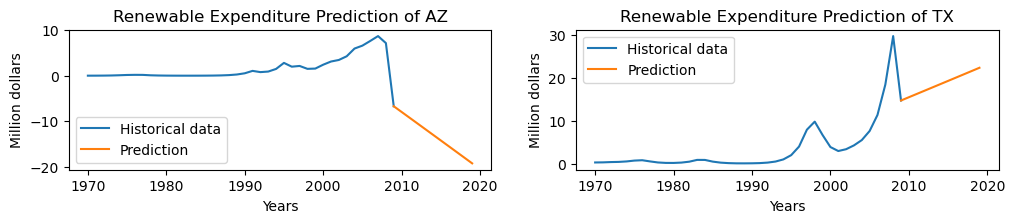

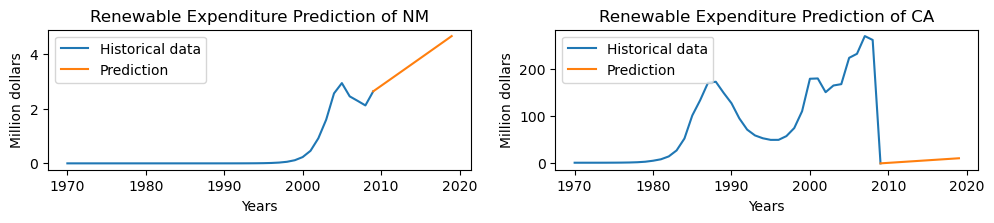

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
ALMOST_DUAL_INFEASIBLE
[-1.3743137370283458; 1.2427735449718131; -0.0006199242244113289]
ALMOST_OPTIMAL
[7.797888845421056; -0.7524690622283919; 0.00037626960207364407]
ALMOST_OPTIMAL
[0.31044152449633344; -0.19818773031186018; 9.922380601536863e-5]
ALMOST_DUAL_INFEASIBLE
[21.630693400631415; -1.1009303999722726; 0.000542310366282844]


┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228


PyObject <matplotlib.legend.Legend object at 0x7f94f9f7b950>

In [235]:
RI_AZ=[0;0;0;0;0.07303;0.23446;0.26318;0.34467;0;0;0;0;0;0;0;0;0;0;0;0;0;2.66616;0;0;0.00046;
    7.13149;0;3.73696;0.10736;0;2.7039;3.83888;2.52181;2.48699;8.09003;5.81706;7.53642;13.92523;5.48284;5.079]
RI_TX=[0.24313;0.22389;0.43594;0.28364;0.35233;0.95066;1.53154;0.48119;0;0;0;0;0.06331;1.73423;
    1.65504;0.17195;0;0.01089;0;0.04032;0.03203;0.00034;0;0.00032;0.00152;0;0.12089;12.0486;
    19.81756;6.04876;0.13675;0.25176;2.44912;3.58654;3.73014;4.40581;4.69884;9.95233;59.9317;18.47303]
RI_NM=[0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0.00172;0;0.46716;1.03648;
    3.72038;4.64416;1.79928;2.29338;2.43676;1.1222]
RI_CA=[0;0;0;0;0;0;0;0;0;0;2.40603;1.19859;0.18541;1.07007;4.07202;133.80328;123.15002;
    239.67325;224.09623;145.0889;146.91056;77.54304;47.24265;45.36716;46.75412;41.68839;32.83609;38.27097;36.28347;43.03918;315.37186;238.8915;63.05621;186.9527;60.95984;317.61828;173.50871;360.94512;334.86721;125.84173]

figure(figsize=(12,4))
subplot(221)
plot(year,RI_AZ)
plot(year,RI_TX)
plot(year,RI_NM)
plot(year,RI_CA)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Import")
legend(["AZ", "TX","NM","CA"])

λ=0.5
(error,smoothness,RI_AZ_opt)=solveOpt(λ,RI_AZ)
(error,smoothness,RI_TX_opt)=solveOpt(λ,RI_TX)
(error,smoothness,RI_NM_opt)=solveOpt(λ,RI_NM)
(error,smoothness,RI_CA_opt)=solveOpt(λ,RI_CA)

subplot(222)
plot(year,RI_AZ_opt)
plot(year,RI_TX_opt)
plot(year,RI_NM_opt)
plot(year,RI_CA_opt)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Import(Fitting)")
legend(["AZ", "TX","NM","CA"])

span=10
P1=ones(11,1)
P2=[i for i in 2009:2019]
P3=[i.^2 for i in 2009:2019]
pre_year=[P1 P2 P3]
xopt=solveOpt1(λ,RI_AZ_opt,span)
pre_RI_AZ=pre_year*xopt
RI_AZ_opt[end]=pre_RI_AZ[1]

xopt=solveOpt1(λ,RI_TX_opt,span)
pre_RI_TX=pre_year*xopt
pre_RI_TX=pre_year*xopt
RI_TX_opt[end]=pre_RI_TX[1]

xopt=solveOpt1(λ,RI_NM_opt,span)
pre_RI_NM=pre_year*xopt
pre_RI_NM=pre_year*xopt
RI_NM_opt[end]=pre_RI_NM[1]

xopt=solveOpt1(λ,RI_CA_opt,span)
pre_RI_CA=pre_year*xopt
pre_RI_CA=pre_year*xopt
RI_CA_opt[end]=pre_RI_CA[1]


figure(figsize=(12,4))
subplot(221)
plot(year,RI_AZ_opt)
plot(P2,pre_RI_AZ)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Expenditure Prediction of AZ")
legend(["Historical data","Prediction"])


subplot(222)
plot(year,RI_TX_opt)
plot(P2,pre_RI_TX)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Expenditure Prediction of TX")
legend(["Historical data","Prediction"])

figure(figsize=(12,4))
subplot(221)
plot(year,RI_NM_opt)
plot(P2,pre_RI_NM)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Expenditure Prediction of NM")
legend(["Historical data","Prediction"])

subplot(222)
plot(year,RI_CA_opt)
plot(P2,pre_RI_CA)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Expenditure Prediction of CA")
legend(["Historical data","Prediction"])


$RE=\frac{ELEXP*ELEXD}{0.00029307107*1000000}-ELEXV$

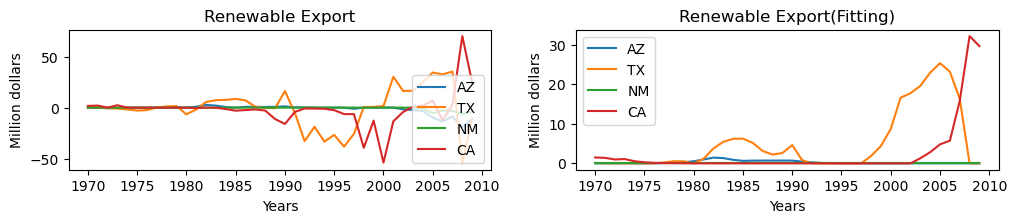

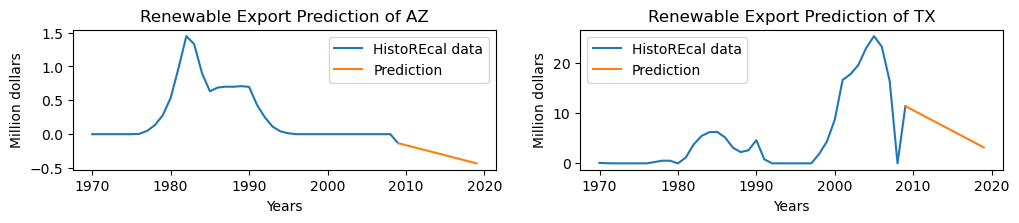

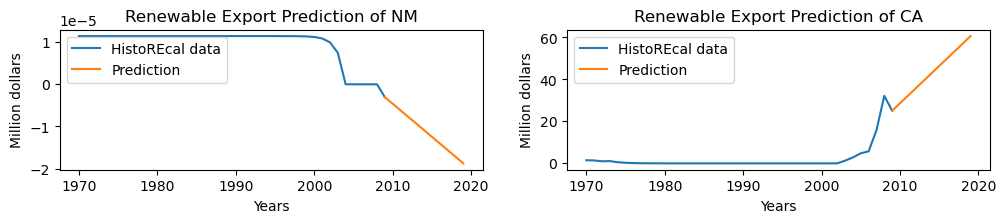

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
ALMOST_OPTIMAL
[0.11569415755976346; 0.029407499557652313; -1.4699445121779016e-5]
ALMOST_OPTIMAL
[0.0008120637506342226; 0.8273583366415027; -0.00040900927120214933]
OPTIMAL
[1.545958102956045e-9; 1.5600750607051895e-6; -7.773005294009401e-10]
ALMOST_OPTIMAL
[-0.003490827824898495; -3.5130677361442166; 0.0017548816008241927]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228


PyObject <matplotlib.legend.Legend object at 0x7f94fb8000d0>

In [242]:
ELEXP_AZ=[14.9845;14.2277;20.5183;22.9603;25.3575;28.5527;30.4248;34.0973;37.71104;44.0679;
    51.36976;60.52752;132.53506;94.06932;28.76764;31.5436;38.39368;37.69776;35.8786;39.541;
    40.54;10.673;6.819;1.107;1.25;0;1.528;1.52;1.786;2.065;2.074;2.177;2.166;2.255;2.488;0.567;
    2.641;48.36;0;0;0;0;68.52477;71.0591;93.54995;179.29595;309.77789;220.94896;350.59231;354.01654]
ELEXP_TX=[207.87755;184.0872;172.50273;185.70769;130.36677;82.9049;90.73288;98.6464;112.755;
    145.7057;159.07836;193.5602;273.159;354.82633;382.94506;414.33209;349.60914;81.53788;16.53932;
    27.908;580.939;289.13;6.954;8.396;9.265;9.494;10.497;40.013;31.725;59.713;64.596;446.823;
    962.41;801.04;964.77;925.37;1029.628;1103.53;4.625;19.575;18.598;2.839;299.15523;296.6209;
    294.68305;297.81205;291.88311;402.73004;1012.87969;337.14646]
ELEXP_NM=[0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;
    0;0;0;22.224;97.762;64.851;61.505;118.004;115.399]
ELEXP_CA=[399.59696;439.87325;457.21964;445.1401;23.372;2.964;0;0;0;0;10.76061;10.89476;0;
    1.45479;0;0;0;0;0;0;12.82;35.264;0;6.877;68.291;142.899;114.262;88.583;145.118;558.729;
    523.792;167.628;25.311;45.872;101.41;228.484;283.356;351.817;1968.578;1263.94;2126.103;
    365.041;196.923;22.51;48.074;103.051;564.692;292.736;674.638;518.488]

ELEXD_AZ=[1.2653;1.36454;1.43897;1.55061;2.09643;2.56781;2.74148;3.10122;3.46096;3.78349;
    4.5774;5.32169;6.14041;6.15282;5.99156;0;6.11561;5.91844;5.83253;5.86292;9.18039;9.46799;
    10.05975;6.93441;10.2239;8.54156;10.98831;7.08249;0;0;0;0;7.19946;9.60208;10.87584;
    16.03628;12.95309;14.77134;15.86967;9.635]
ELEXD_TX=[1.2653;1.36454;1.43897;1.55061;2.09643;2.56781;2.74148;3.10122;3.46096;3.78349;
    4.5774;5.32169;6.14041;6.15282;5.99156;6.16523;6.11561;5.91844;5.83253;5.86292;9.18039;
    9.46799;10.05975;6.93441;10.2239;8.54156;10.98831;7.08249;6.31999;5.28003;9.85637;19.89946;
    7.19946;9.60208;10.87584;16.03628;12.95309;14.77134;15.86967;9.635]
ELEXD_NM=[0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;10.87584;16.03628;
    12.95309;14.77134;15.86967;9.635]
ELEXD_CA=[1.2653;1.36454;0;1.55061;0;0;0;0;0;0;4.5774;5.32169;0;6.15282;5.99156;6.16523;
    6.11561;5.91844;5.83253;5.86292;9.18039;9.46799;10.05975;6.93441;10.2239;8.54156;10.98831;
    7.08249;6.31999;5.28003;9.85637;19.89946;7.19946;9.60208;10.87584;16.03628;12.95309;14.77134;15.86967;9.635]

ELEXV_AZ=[0.22177;0.2818;0.65072;0.49769;0.20578;0.27637;0.35913;0.39889;0.42368;0.51045;0.63316;
    0.1938;0.14287;0.02324;0.02555;0;0.03188;0.03069;0.03554;0.04131;0.06496;0.07033;0.07435;
    0.05335;0.08679;0.01652;0.09902;1.16864;0;0;0;0;1.68328;2.32806;3.47149;9.81032;13.69093;
    11.13579;18.98363;11.63816]
ELEXV_TX=[0.68677;0.90118;1.34115;1.87727;2.73921;3.63012;3.27022;0.86278;0.19531;0.36027;
    9.07316;5.24991;0.14569;0.17626;0.18941;0.19971;0.21904;0.80801;0.63135;1.19452;2.02337;
    14.43452;33.03363;18.95277;33.65499;26.9688;38.60293;26.66731;0.09973;0.35265;0.62545;
    0.19276;7.34862;9.71798;10.93521;16.29502;12.90005;20.29752;54.84471;11.08356]
ELEXV_NM=[0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0.8247;5.34912;
    2.86615;3.09984;6.3896;3.7937]
ELEXV_CA=[0.04646;0.05072;0;0.0077;0;0;0;0;0;0;0.20022;0.64031;0;0.14437;1.39609;3.00599;
    2.38424;1.78882;2.88793;11.17697;16.40699;5.41519;0.86877;1.08534;3.53758;6.65889;
    10.62362;8.50182;42.45003;22.77046;71.5007;24.78517;4.83733;0.73748;1.78395;5.63852;
    24.9571;14.75384;36.52984;17.0451]

RE_AZ=[(ELEXP_AZ[i]*ELEXD_AZ[i])/(0.00029307107*1000000)-ELEXV_AZ[i] for i in 1:40]
RE_TX=[(ELEXP_TX[i]*ELEXD_TX[i])/(0.00029307107*1000000)-ELEXV_TX[i] for i in 1:40]
RE_NM=[(ELEXP_NM[i]*ELEXD_NM[i])/(0.00029307107*1000000)-ELEXV_NM[i] for i in 1:40]
RE_CA=[(ELEXP_CA[i]*ELEXD_CA[i])/(0.00029307107*1000000)-ELEXV_CA[i] for i in 1:40]
figure(figsize=(12,4))
subplot(221)
plot(year,RE_AZ)
plot(year,RE_TX)
plot(year,RE_NM)
plot(year,RE_CA)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Export")
legend(["AZ", "TX","NM","CA"])

λ=0.5
(error,smoothness,RE_AZ_opt)=solveOpt(λ,RE_AZ)
(error,smoothness,RE_TX_opt)=solveOpt(λ,RE_TX)
(error,smoothness,RE_NM_opt)=solveOpt(λ,RE_NM)
(error,smoothness,RE_CA_opt)=solveOpt(λ,RE_CA)

subplot(222)
plot(year,RE_AZ_opt)
plot(year,RE_TX_opt)
plot(year,RE_NM_opt)
plot(year,RE_CA_opt)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Export(Fitting)")
legend(["AZ", "TX","NM","CA"])


span=10
P1=ones(11,1)
P2=[i for i in 2009:2019]
P3=[i.^2 for i in 2009:2019]
pre_year=[P1 P2 P3]
xopt=solveOpt1(λ,RE_AZ_opt,span)
pre_RE_AZ=pre_year*xopt
RE_AZ_opt[end]=pre_RE_AZ[1]

xopt=solveOpt1(λ,RE_TX_opt,span)
pre_RE_TX=pre_year*xopt
pre_RE_TX=pre_year*xopt
RE_TX_opt[end]=pre_RE_TX[1]

xopt=solveOpt1(λ,RE_NM_opt,span)
pre_RE_NM=pre_year*xopt
pre_RE_NM=pre_year*xopt
RE_NM_opt[end]=pre_RE_NM[1]

xopt=solveOpt1(λ,RE_CA_opt,span)
pre_RE_CA=pre_year*xopt
pre_RE_CA=pre_year*xopt
RE_CA_opt[end]=pre_RE_CA[1]


figure(figsize=(12,4))
subplot(221)
plot(year,RE_AZ_opt)
plot(P2,pre_RE_AZ)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Export Prediction of AZ")
legend(["HistoREcal data","Prediction"])


subplot(222)
plot(year,RE_TX_opt)
plot(P2,pre_RE_TX)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Export Prediction of TX")
legend(["HistoREcal data","Prediction"])

figure(figsize=(12,4))
subplot(221)
plot(year,RE_NM_opt)
plot(P2,pre_RE_NM)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Export Prediction of NM")
legend(["HistoREcal data","Prediction"])

subplot(222)
plot(year,RE_CA_opt)
plot(P2,pre_RE_CA)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Renewable Export Prediction of CA")
legend(["HistoREcal data","Prediction"])

Renewable energy total consumption(RETCB) and renewable energy total production(REPRB) are important for later optimization of energy distribution among states.

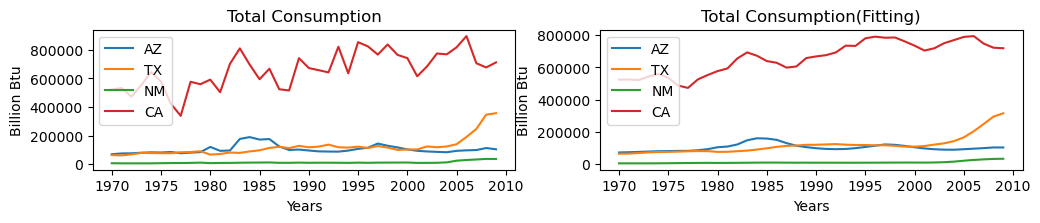

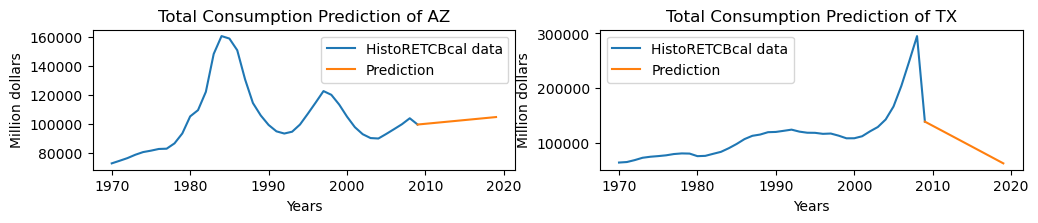

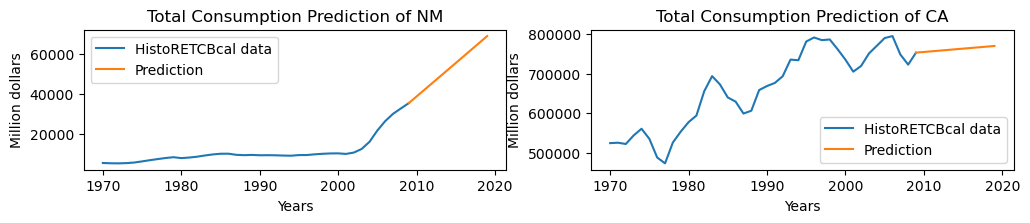

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
ALMOST_OPTIMAL
[6134.21234413702; -422.571606790067; 0.233444024995356]
ALMOST_OPTIMAL
[597931.2998332448; 7110.962202940854; -3.653208736564898]
ALMOST_OPTIMAL
[-3.2918042737050404; -3308.5623282062; 1.6556068087688334]
ALMOST_OPTIMAL
[-1.4198867958882444e6; 482.1563843321398; 0.29830001785986926]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228


PyObject <matplotlib.legend.Legend object at 0x7f950abe3050>

In [247]:
RETCB_AZ=[36181.45337;35082.71035;34533.37394;34861.20332;34270.82091;50095.02821;58059.82217;
    56422.66903;63456.3526;67840.06237;68919.16257;74136.25194;75188.74432;79348.45429;
    82058.08613;80897.34186;84428.48089;75680.87057;79869.7173;83413.77083;120006.4291;
    92583.03952;94968.34525;175999.0286;188831.349;171680.4225;175102.7767;123113.582;
    98749.30689;101553.8173;94816.36936;88844.17798;87592.987;87022.70044;94324.87168;
    106304.677;114186.1258;143638.9491;128258.1248;116535.3262;102625.9402;92736.79325;
    88265.46719;85280.50679;82799.60867;92489.6057;96082.13234;98077.97179;112169.6469;103493.2854]
RETCB_TX=[50154.98177;52022.85304;47721.24979;42717.86659;43884.2564;48966.77921;51980.12089;
    49944.1609;62938.87125;64351.45971;62756.82021;60470.71299;67559.72792;78101.59584;
    76691.32086;75871.68555;75964.66534;82565.80703;84175.21416;89720.8005;65818.6753;
    70515.77613;80753.13672;78067.25711;88645.53325;96301.17597;113055.793;120708.9929;
    111779.9304;127599.786;117295.1994;122321.6626;136108.7629;117754.1535;115392.3267;
    122114.8283;112113.7545;126386.4059;115580.3619;98999.84377;101768.2984;102051.7296;
    123453.1378;117846.7295;123193.9731;138956.3433;190304.644;245931.4351;346412.8352;356634.8206]
RETCB_NM=[7373.05583;6936.51555;6791.46314;6468.79948;6299.60702;6074.90564;6209.5118;
    5678.48447;5705.58598;5681.81484;5547.61237;4964.65394;4745.50766;4895.8681;4918.59476;
    6002.3454;6781.05597;7327.52063;7989.09471;9921.6861;6222.6322;7731.2666;8034.90149;
    9200.70962;9926.48398;10520.99098;11126.70674;8592.94641;8594.17854;9928.15283;8729.48362;
    9356.09125;9319.15144;8851.42503;8170.27972;9803.50494;8611.54468;9781.89609;10065.19479;
    10334.52736;10719.44735;7924.46009;8195.37527;8800.1346;11721.09552;23514.3723;28322.22471;
    31839.10226;35996.44258;35635.38371]
RETCB_CA=[270161.0892;248177.5248;329045.7467;360333.3104;331756.585;418517.8278;375877.0183;
    473191.9968;397365.9154;544918.0085;521978.1167;533790.0941;472311.9171;553161.7389;
    645073.0418;578577.8801;422851.6023;338072.6862;576600.8718;559805.6495;591927.6271;
    503653.7258;702807.7046;811006.1706;696739.9462;594659.3254;668070.3983;524441.4501;
    515856.1295;742317.8185;673021.572;658177.2104;642495.6129;822465.2016;636059.7725;
    854610.5196;824981.4822;767468.538;838296.0609;765491.9273;742639.4822;615357.5253;
    684706.464;775046.7826;769402.7643;818802.7598;897231.6446;706849.15;677502.4609;712704.4602]


figure(figsize=(12,4))
subplot(221)
plot(year,RETCB_AZ[11:50])
plot(year,RETCB_TX[11:50])
plot(year,RETCB_NM[11:50])
plot(year,RETCB_CA[11:50])
plt.ylabel("Billion Btu")
plt.xlabel("Years")
plt.title("Total Consumption")
legend(["AZ", "TX","NM","CA"])

λ=0.5
(error,smoothness,RETCB_AZ_opt)=solveOpt(λ,RETCB_AZ[11:50])
(error,smoothness,RETCB_TX_opt)=solveOpt(λ,RETCB_TX[11:50])
(error,smoothness,RETCB_NM_opt)=solveOpt(λ,RETCB_NM[11:50])
(error,smoothness,RETCB_CA_opt)=solveOpt(λ,RETCB_CA[11:50])

subplot(222)
plot(year,RETCB_AZ_opt)
plot(year,RETCB_TX_opt)
plot(year,RETCB_NM_opt)
plot(year,RETCB_CA_opt)
plt.ylabel("Billion Btu")
plt.xlabel("Years")
plt.title("Total Consumption(Fitting)")
legend(["AZ", "TX","NM","CA"])

span=10
P1=ones(11,1)
P2=[i for i in 2009:2019]
P3=[i.^2 for i in 2009:2019]
pre_year=[P1 P2 P3]
xopt=solveOpt1(λ,RETCB_AZ_opt,span)
pre_RETCB_AZ=pre_year*xopt
RETCB_AZ_opt[end]=pre_RETCB_AZ[1]

xopt=solveOpt1(λ,RETCB_TX_opt,span)
pre_RETCB_TX=pre_year*xopt
pre_RETCB_TX=pre_year*xopt
RETCB_TX_opt[end]=pre_RETCB_TX[1]

xopt=solveOpt1(λ,RETCB_NM_opt,span)
pre_RETCB_NM=pre_year*xopt
pre_RETCB_NM=pre_year*xopt
RETCB_NM_opt[end]=pre_RETCB_NM[1]

xopt=solveOpt1(λ,RETCB_CA_opt,span)
pre_RETCB_CA=pre_year*xopt
pre_RETCB_CA=pre_year*xopt
RETCB_CA_opt[end]=pre_RETCB_CA[1]


figure(figsize=(12,4))
subplot(221)
plot(year,RETCB_AZ_opt)
plot(P2,pre_RETCB_AZ)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Total Consumption Prediction of AZ")
legend(["HistoRETCBcal data","Prediction"])


subplot(222)
plot(year,RETCB_TX_opt)
plot(P2,pre_RETCB_TX)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Total Consumption Prediction of TX")
legend(["HistoRETCBcal data","Prediction"])

figure(figsize=(12,4))
subplot(221)
plot(year,RETCB_NM_opt)
plot(P2,pre_RETCB_NM)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Total Consumption Prediction of NM")
legend(["HistoRETCBcal data","Prediction"])

subplot(222)
plot(year,RETCB_CA_opt)
plot(P2,pre_RETCB_CA)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Total Consumption Prediction of CA")
legend(["HistoRETCBcal data","Prediction"])




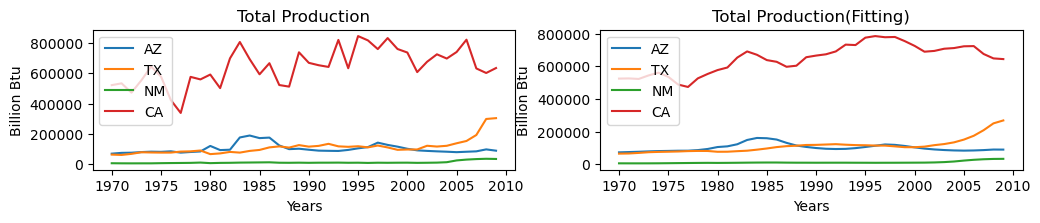

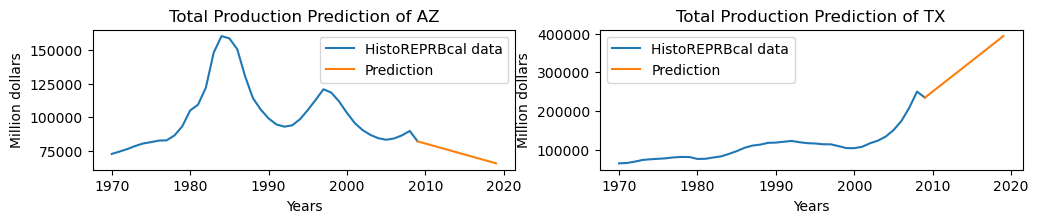

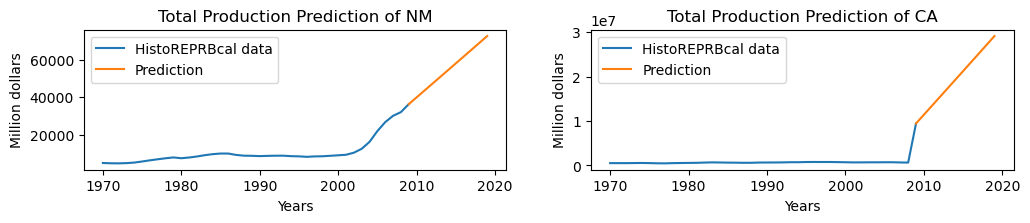

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
ALMOST_OPTIMAL
[1.726518730149033; 1718.8998440224186; -0.8353136860941798]
ALMOST_OPTIMAL
[79788.0306872416; -15667.398349946337; 7.836931187340738]
ALMOST_OPTIMAL
[-3.534544569785291; -3547.498430921239; 1.7748197557163978]
ALMOST_OPTIMAL
[7.095050048909846e7; -2.0186429753968143e6; 989.5635487288192]


┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /Users/user/.julia/packages/Convex/Y9BWU/src/solution.jl:228


PyObject <matplotlib.legend.Legend object at 0x7f950e698b10>

In [248]:
REPRB_AZ=[36181.45337;35082.71035;34533.37394;34861.20332;34270.82091;50095.02821;58059.82217;
    56422.66903;63456.3526;67840.06237;68919.16257;74136.25194;75188.74432;79348.45429;82058.08613;
    80897.34186;84428.48089;75680.87057;79869.7173;83413.77083;120006.4291;92565.30497;94926.31913;
    175992.8019;188831.349;171680.4225;175102.7767;123113.582;98749.30689;101553.8173;94816.36936;
    88844.17798;87592.987;86746.38756;93601.96834;104031.3196;112268.7753;141734.1489;126789.6308;
    115266.0058;101173.029;90726.10341;87119.08004;84174.63139;81735.55497;78743.84169;81533.37169;
    84167.97886;97134.51742;88571.38442]
REPRB_TX=[50154.98177;52022.85304;47721.24979;42717.86659;43884.2564;48966.77921;51980.12089;
    49944.1609;62938.87125;64351.45971;62756.82021;60470.71299;67559.72792;78101.59584;76691.32086;
    75871.68555;75964.66534;82565.80703;84175.21416;89720.8005;65818.6753;70519.70929;80451.75036;
    75816.82064;87063.95791;93531.88383;110360.0582;116904.6119;108935.5132;125462.5766;115298.0231;
    120335.4345;133856.0867;117234.4637;114104.0195;117897.9075;110543.9195;122677.2841;110086.5272;
    94267.21986;96346.13836;96563.3496;121061.9406;115899.6095;120886.6667;137564.5865;152714.6303;
    192261.4163;298182.5907;303697.0626]
REPRB_NM=[7373.05583;6936.51555;6791.46314;6468.79948;6299.60702;6074.90564;6209.5118;5678.48447;
    5705.58598;5681.81484;5547.61237;4964.65394;4745.50766;4895.8681;4918.59476;6002.3454;6781.05597;
    7327.52063;7989.09471;9921.6861;6222.6322;7850.4533;8424.96074;9738.56586;10331.96832;
    10998.46499;11712.7992;8882.21042;8485.00705;9284.61705;8346.85973;9150.21571;9265.24712;
    9679.52988;8615.42933;9088.37558;7603.07227;9043.9492;8486.77166;9072.69223;9310.21296;
    8053.59275;8718.53593;9628.8265;12366.59947;24106.54545;29641.4582;33024.11335;35036.03687;33785.17435]
REPRB_CA=[270161.0892;248177.5248;329045.7467;360333.3104;331756.585;418517.8278;375877.0183;
    473191.9968;397365.9154;544918.0085;521978.1167;533790.0941;472311.9171;553161.7389;
    645073.0418;578577.8801;422851.6023;338072.6862;576600.8718;559805.6495;591927.6271;
    502231.5458;698981.1158;807127.7762;693614.2766;593488.3488;666981.2634;522673.4923;
    512100.1252;738965.0816;669385.4202;653580.5176;642312.7534;820857.3861;633675.3982;
    846265.1547;817765.8562;760363.1024;833063.9545;760981.8777;737522.9182;608143.3519;
    676324.8087;725742.0208;697820.3088;741050.6527;822410.1238;632367.5091;602233.0464;
    635062.3653]

figure(figsize=(12,4))
subplot(221)
plot(year,REPRB_AZ[11:50])
plot(year,REPRB_TX[11:50])
plot(year,REPRB_NM[11:50])
plot(year,REPRB_CA[11:50])
plt.ylabel("Billion Btu")
plt.xlabel("Years")
plt.title("Total Production")
legend(["AZ", "TX","NM","CA"])

λ=0.5
(error,smoothness,REPRB_AZ_opt)=solveOpt(λ,REPRB_AZ[11:50])
(error,smoothness,REPRB_TX_opt)=solveOpt(λ,REPRB_TX[11:50])
(error,smoothness,REPRB_NM_opt)=solveOpt(λ,REPRB_NM[11:50])
(error,smoothness,REPRB_CA_opt)=solveOpt(λ,REPRB_CA[11:50])

subplot(222)
plot(year,REPRB_AZ_opt)
plot(year,REPRB_TX_opt)
plot(year,REPRB_NM_opt)
plot(year,REPRB_CA_opt)
plt.ylabel("Billion Btu")
plt.xlabel("Years")
plt.title("Total Production(Fitting)")
legend(["AZ", "TX","NM","CA"])

span=10
P1=ones(11,1)
P2=[i for i in 2009:2019]
P3=[i.^2 for i in 2009:2019]
pre_year=[P1 P2 P3]
xopt=solveOpt1(λ,REPRB_AZ_opt,span)
pre_REPRB_AZ=pre_year*xopt
REPRB_AZ_opt[end]=pre_REPRB_AZ[1]

xopt=solveOpt1(λ,REPRB_TX_opt,span)
pre_REPRB_TX=pre_year*xopt
pre_REPRB_TX=pre_year*xopt
REPRB_TX_opt[end]=pre_REPRB_TX[1]

xopt=solveOpt1(λ,REPRB_NM_opt,span)
pre_REPRB_NM=pre_year*xopt
pre_REPRB_NM=pre_year*xopt
REPRB_NM_opt[end]=pre_REPRB_NM[1]

xopt=solveOpt1(λ,REPRB_CA_opt,span)
pre_REPRB_CA=pre_year*xopt
pre_REPRB_CA=pre_year*xopt
REPRB_CA_opt[end]=pre_REPRB_CA[1]


figure(figsize=(12,4))
subplot(221)
plot(year,REPRB_AZ_opt)
plot(P2,pre_REPRB_AZ)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Total Production Prediction of AZ")
legend(["HistoREPRBcal data","Prediction"])


subplot(222)
plot(year,REPRB_TX_opt)
plot(P2,pre_REPRB_TX)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Total Production Prediction of TX")
legend(["HistoREPRBcal data","Prediction"])

figure(figsize=(12,4))
subplot(221)
plot(year,REPRB_NM_opt)
plot(P2,pre_REPRB_NM)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Total Production Prediction of NM")
legend(["HistoREPRBcal data","Prediction"])

subplot(222)
plot(year,REPRB_CA_opt)
plot(P2,pre_REPRB_CA)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Total Production Prediction of CA")
legend(["HistoREPRBcal data","Prediction"])


Production-consumption difference(PCD) in the predicted years.
$$PCD=REPRB-RETCB$$

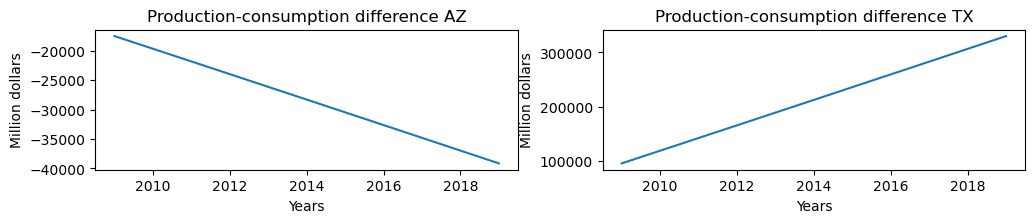

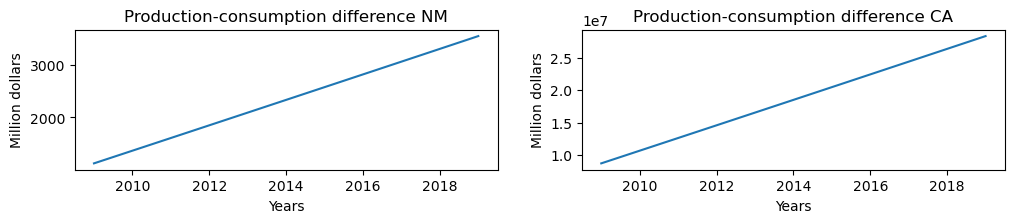

PyObject Text(0.5, 1.0, 'Production-consumption difference CA')

In [251]:
PCD_AZ=pre_REPRB_AZ-pre_RETCB_AZ
figure(figsize=(12,4))
subplot(221)
plot(P2,PCD_AZ)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Production-consumption difference AZ")

PCD_TX=pre_REPRB_TX-pre_RETCB_TX
subplot(222)
plot(P2,PCD_TX)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Production-consumption difference TX")

PCD_NM=pre_REPRB_NM-pre_RETCB_NM
figure(figsize=(12,4))
subplot(221)
plot(P2,PCD_NM)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Production-consumption difference NM")

PCD_CA=pre_REPRB_CA-pre_RETCB_CA
subplot(222)
plot(P2,PCD_CA)
plt.ylabel("Million dollars")
plt.xlabel("Years")
plt.title("Production-consumption difference CA")